In [34]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [35]:
sns.set(style="darkgrid", font_scale=1.5)

In [36]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

After importing the libraries, we can now get the data we need:

In [37]:
df = pd.read_csv("../../data/MorningTest.csv")[['price']]

# Subsample data, original is every second
# df = df.iloc[::60]
# df = df.reset_index(drop=True)

df.shape

(37000, 1)

In [38]:
print("Shape: ", df.shape)
df.head()

Shape:  (37000, 1)


,price
0,1239.365
1,1239.420
2,1239.540
3,1239.780
4,1239.770


# Plotting Price

Text(0.5, 1.0, 'Price of ETHER')

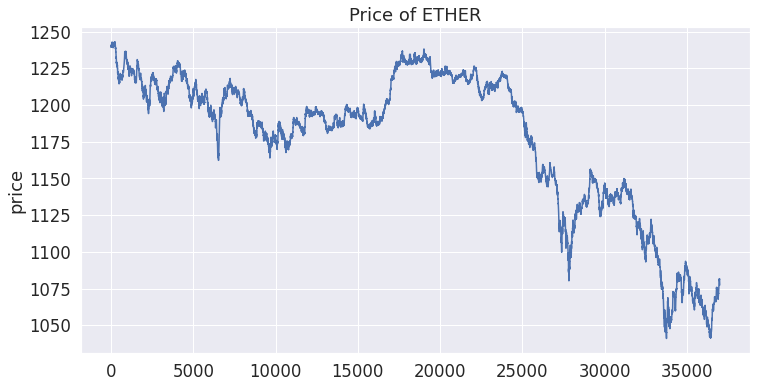

In [39]:
plt.figure(figsize=(12,6))
sns.lineplot(x=df.index, y="price", data=df).set_title("Price of ETHER")

In [40]:
#df.resample('.01D').mean().plot(figsize=(12,6))
#plt.figtext(.5,0.9,"Down-sampled to 10-day periods", fontsize=20, ha='center')

# Model

Long short-term memory (LSTM) is a type of recurrent neural network (RNN) and powerful to model sequence data because it maintains an internal state to keep track of the data it has already seen. Common applications of LSTMs include time series analysis and natural language processing.

LSTM requires the input to be a 3D tensor with shape (batch_size, timesteps, input_dim).

Batch_size: 
Timesteps:
input_dim:

I will build a model that predicts the value of litecoin at time t using the past 90 values (from t-90 to t-1). Therefore the the number of timesteps is 90. I only use "open" price to make the prediction so the input_dim is 1. The target variable is "open" price of litecoin which can be effected by many other factors. For example, the value of another crptocurrency may have an effect on litecoin. If we also use a second variable to make the prediction, than the input_dim will be 2.

## Data Preprocessing

I will re-organize the data in a way that a sequence of the values in previous 90 days is used to predict the value at time t. It is also better to normalize the values due to excessive computations done in a neural network.

In [41]:
data = df.iloc[:, 0]
data

0        1239.365000
1        1239.420000
2        1239.540000
3        1239.780000
4        1239.770000
            ...     
36995    1078.356875
36996    1078.148406
36997    1077.701899
36998    1077.549158
36999    1077.389566
Name: price, Length: 37000, dtype: float64

In [42]:
hist = []
target = []

# Length is an adjustable parameter
length = 90

for i in range(len(data)-length):
    x = data[i:i+length]
    y = data[i+length]
    hist.append(x)
    target.append(y)

In [43]:
print("History is of length:\t", len(hist), "with each element representing", len(hist[0]), f"past prices t-{length} to t-1")
print("Target is of length:\t", len(target), f"with each element representing what the price at time t really is. Ex: target[0]=${target[0]}")

History is of length:	 36910 with each element representing 90 past prices t-90 to t-1
Target is of length:	 36910 with each element representing what the price at time t really is. Ex: target[0]=$1241.595


In [44]:
print(hist[0][length-1])
print(data[length-1])

1241.720037
1241.720037


In [45]:
#convert list to array
hist = np.array(hist)
target = np.array(target)

target = target.reshape(-1,1)

print("hist shape", hist.shape)
print("target shape", target.shape)

hist shape (36910, 90)
target shape (36910, 1)


In [46]:
#Normalize the values
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
hist_scaled = sc.fit_transform(hist)
target_scaled = sc.fit_transform(target)

In [47]:
#Reshape the input
hist_scaled = hist_scaled.reshape((len(hist_scaled), length, 1))
print(hist_scaled.shape)

# hist scaled: Array of dims [length of origional data - length][length][1 (means each gets it's own box)]
print(hist_scaled[0][1])
print(hist_scaled[1][0])

(36910, 90, 1)
[0.98227167]
[0.98227167]


## Training and test sets

Our dataset includes 1951 samples (days). A sample of input consists of the value of litecoin for 90 consecutive days and target variable is the value of litecoin on the following day after the 90-day period.

I will split the dataset in a way that 1900 samples are used for training and then the model will be used to predict the trend in the following 51 days


In [48]:
points_for_testing = 200
points_for_training = len(hist_scaled) - points_for_testing

X_train = hist_scaled[:points_for_training,:,:]
X_test = hist_scaled[points_for_training:,:,:]

y_train = target_scaled[:points_for_training,:]
y_test = target_scaled[points_for_training:,:]

print(f"Using {len(y_test)} datapoints for testing, leaving {len(y_train)} points for training")

Using 200 datapoints for testing, leaving 36710 points for training


## Building the neural network

In [49]:
import tensorflow as tf

from tensorflow.keras import layers, optimizers

In [50]:
model = tf.keras.Sequential()

model.add(layers.LSTM(units=32, return_sequences=True,
                  input_shape=(length,1), dropout=0.2))

model.add(layers.LSTM(units=32, return_sequences=True,
                  dropout=0.2))

model.add(layers.LSTM(units=32, dropout=0.2))

model.add(layers.Dense(units=1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 90, 32)            4352      
_________________________________________________________________
lstm_4 (LSTM)                (None, 90, 32)            8320      
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 21,025
Trainable params: 21,025
Non-trainable params: 0
_________________________________________________________________


In [51]:
optimizer = optimizers.Adam()
model.compile(optimizer=optimizer, loss='mean_squared_error')

In [52]:
history = model.fit(X_train, y_train, epochs=6, batch_size=32)

Epoch 1/6
1148/1148 [==============================] - 48s 39ms/step - loss: 0.0180
Epoch 2/6
1148/1148 [==============================] - 45s 39ms/step - loss: 5.7909e-04
Epoch 3/6
1148/1148 [==============================] - 45s 40ms/step - loss: 3.5901e-04
Epoch 4/6
1148/1148 [==============================] - 46s 40ms/step - loss: 3.1165e-04
Epoch 5/6
1148/1148 [==============================] - 46s 40ms/step - loss: 2.9235e-04
Epoch 6/6
1148/1148 [==============================] - 47s 41ms/step - loss: 2.5293e-04


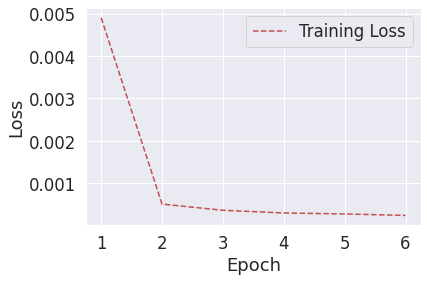

In [53]:
loss = history.history['loss']
epoch_count = range(1, len(loss) + 1)
plt.figure(figsize=(6,4))
plt.plot(epoch_count, loss, 'r--')
plt.legend(['Training Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Predict

In [54]:
X_test.shape

(200, 90, 1)

In [55]:
pred = model.predict(X_test)

In [56]:
pred_transformed = sc.inverse_transform(pred)
y_test_transformed = sc.inverse_transform(y_test)

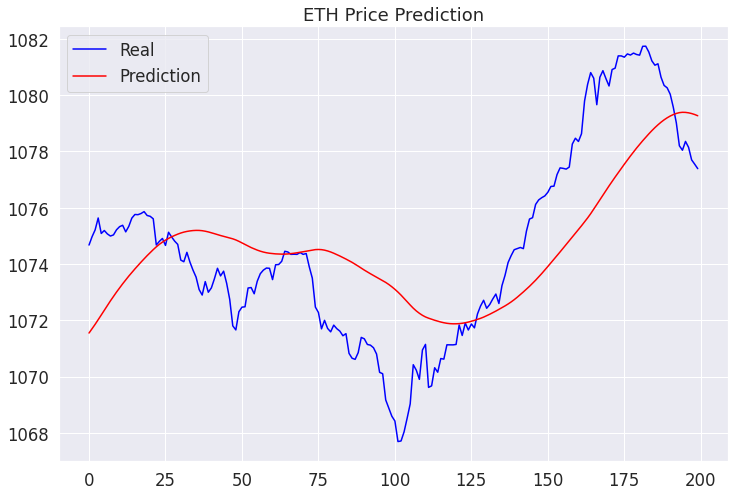

In [57]:
plt.figure(figsize=(12,8))
plt.plot(y_test_transformed, color='blue', label='Real')
plt.plot(pred_transformed, color='red', label='Prediction')
plt.title('ETH Price Prediction')
plt.legend()
plt.show()

# Single Prediction

In [58]:
# For example, if we just want to predict the next timestep in the dataset we can prepare it as such:

# 1. get the [length] last points from the data set since that's what we care about
most_recent_period = df.tail(length)

# 2. convert to numpy array 
most_recent_period = np.array(most_recent_period)

# 3. normalize data
scaler = MinMaxScaler()
most_recent_period_scaled = scaler.fit_transform(most_recent_period)

# 4. reshape to the 3D tensor we expected (1, length, 1)
most_recent_period_scaled_shaped = most_recent_period_scaled.reshape((1, length, 1))

# 5. Predict
prediction = model.predict(most_recent_period_scaled_shaped)

# 6. Un-normalize the data
result = scaler.inverse_transform(prediction)

print(f"${result[0][0]}")

$1078.3673095703125


# Prediction Success Evaluation

In [60]:
def sub_sample(arr1, arr2, sub):
    return (arr1[::sub], arr2[::sub])

def evaluate_model(real_data, predicted_data):
    real_data = real_data.reshape(len(real_data))
    predicted_data = predicted_data.reshape(len(predicted_data))

    real_diff = np.diff(real_data)
    predicted_diff = np.diff(predicted_data)

    correct_slopes = 0
    profit = 0
    for i in range(len(real_data)-1):
        if np.sign(real_diff[i]) == np.sign(predicted_diff[i]):
            correct_slopes = correct_slopes + 1
            
            # If we have a positive slope calculate profit
            if real_diff[i] > 0:
                # we subtract $2 due to the limit market mechanics
                revenue = (real_data[i+1] - real_data[i]) - 2
                if revenue > 0:
                    print(f"Found a profit where {real_diff[i]} {predicted_diff[i]} current value is {real_data[i+1]} last was {real_data[i]} net {revenue}")
                    profit = profit + revenue

        else:
            # We guessed wrong
            if predicted_diff[i] > 0:
                # we would have bought
                revenue = (real_data[i+1] - real_data[i]) - 2
                print(f"Selling at a loss of {revenue}")
                profit = profit + revenue

    return (correct_slopes, profit)

# Subsample the test points, this seems to increase accuracy
real_subbed, pred_subbed = sub_sample(y_test_transformed, pred_transformed, 60)

# Determine the number of cases in which we predicted a correct increase
correct_slopes, profit = evaluate_model(real_subbed, pred_subbed)

print(f"Found {correct_slopes} out of {len(real_subbed)-1}")
precent_success = (correct_slopes/(len(real_subbed)-1)) * 100
print(f"{precent_success}%")
print("Profit:", profit)


Selling at a loss of -3.2274010000001
Found a profit where 10.276378999999906 6.3740234375 current value is 1081.421379 last was 1071.145 net 8.276378999999906
Found 2 out of 3
66.66666666666666%
Profit: 5.048977999999806
